In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/envs/tsa_course/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('_sources/TSA_COURSE_NOTEBOOKS/Data/M2SLMoneyStock.csv',index_col=0,parse_dates=True)
df.index.freq='MS'
sp = pd.read_csv('_sources/TSA_COURSE_NOTEBOOKS/Data/PCEPersonalSpending.csv',index_col=0,parse_dates=True)
sp.index.freq='MS'

In [5]:
df.head(3)

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1


In [6]:
df = df.join(sp)

In [9]:
df.shape

(252, 2)

In [7]:
df = df.dropna()

In [8]:
df.shape

(252, 2)

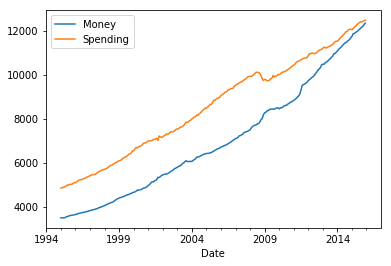

In [10]:
df.plot()

In [11]:
# predefined function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [14]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
df_transformed = df.diff()

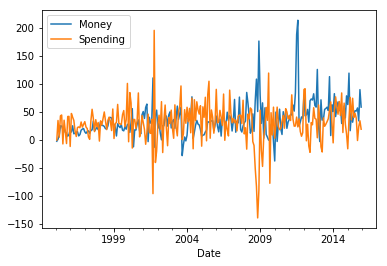

In [22]:
df_transformed.plot()

In [24]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [25]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [28]:
df_transformed = df_transformed.diff().dropna()

In [27]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [50]:
nobs = 12
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

# VAR

### grid search for order p

In [34]:
model = VAR(train)
for p in range(1,15):
    results = model.fit(p)
    print(f'ORDER: {p}')
    print(f'AIC: {results.aic}')

ORDER: 1
AIC: 15.796135308776922
ORDER: 2
AIC: 15.114477556763626
ORDER: 3
AIC: 14.738769101218226
ORDER: 4
AIC: 14.620770001897682
ORDER: 5
AIC: 14.491207086701195
ORDER: 6
AIC: 14.407601002813859
ORDER: 7
AIC: 14.400431369101309
ORDER: 8
AIC: 14.315332595867506
ORDER: 9
AIC: 14.254519689253156
ORDER: 10
AIC: 14.200965338195436
ORDER: 11
AIC: 14.179882624285682
ORDER: 12
AIC: 14.201894192206668
ORDER: 13
AIC: 14.198123325497248
ORDER: 14
AIC: 14.231118015997335


In [35]:
results = model.fit(11) # 5 in course

In [36]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Jul, 2019
Time:                     08:06:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.8761
Nobs:                     226.000    HQIC:                   14.4608
Log likelihood:          -2197.69    FPE:                1.44165e+06
AIC:                      14.1799    Det(Omega_mle):     1.18762e+06
--------------------------------------------------------------------
Results for equation Money
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.015975         1.964202           -0.008           0.994
L1.Money            -1.545475         0.071560          -21.597           0.000
L1.Spending         -0.110163         0.055817           -1.974 

### forecasting

In [43]:
lagged_values = train.values[-11:]

In [52]:
fcast_input = results.forecast(y=lagged_values,steps=12)

In [58]:
df_forecast = pd.DataFrame(data=fcast_input,index=test.index,columns=['Money_2d','Spending_2d'])

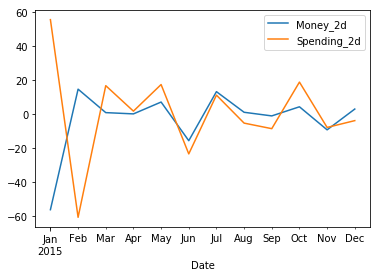

In [59]:
df_forecast.plot()

### inverting the transformation/differencing

In [60]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [61]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [63]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
Date,,,,,,
2015-01-01,-56.298243,55.434108,22.301757,11692.401757,66.034108,12128.034108
2015-02-01,14.558191,-60.779144,36.859948,11729.261705,5.254965,12133.289073
2015-03-01,0.773593,16.624612,37.633541,11766.895246,21.879577,12155.168650
2015-04-01,0.025267,1.640196,37.658808,11804.554054,23.519773,12178.688422
2015-05-01,6.988978,17.277037,44.647787,11849.201841,40.796810,12219.485232


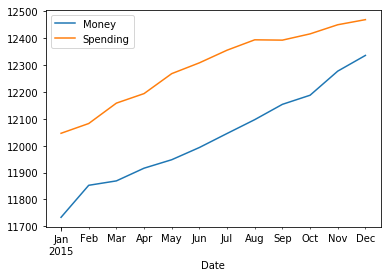

In [75]:
df[-nobs:].plot()

In [69]:
df_forecast.columns

Index(['Money_2d', 'Spending_2d', 'Money1d', 'MoneyForecast', 'Spending1d',
       'SpendingForecast'],
      dtype='object')

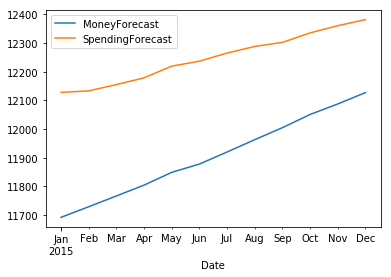

In [71]:
df_forecast[['MoneyForecast','SpendingForecast']].plot()

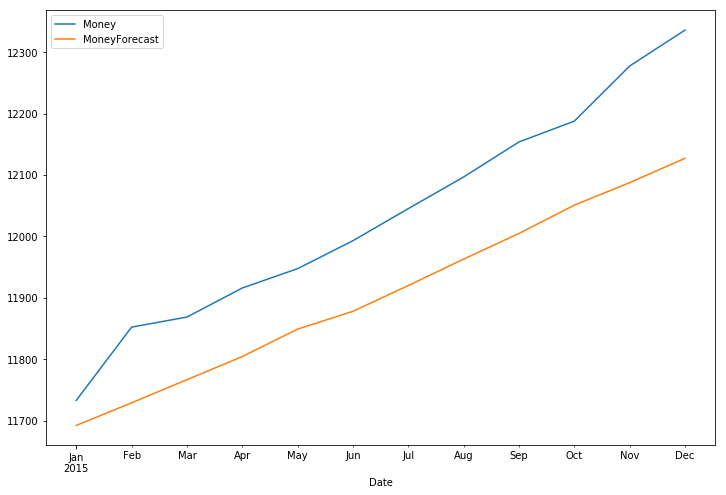

In [81]:
df[-nobs:]['Money'].plot(legend=True,figsize=(12,8))
df_forecast['MoneyForecast'].plot(legend=True)

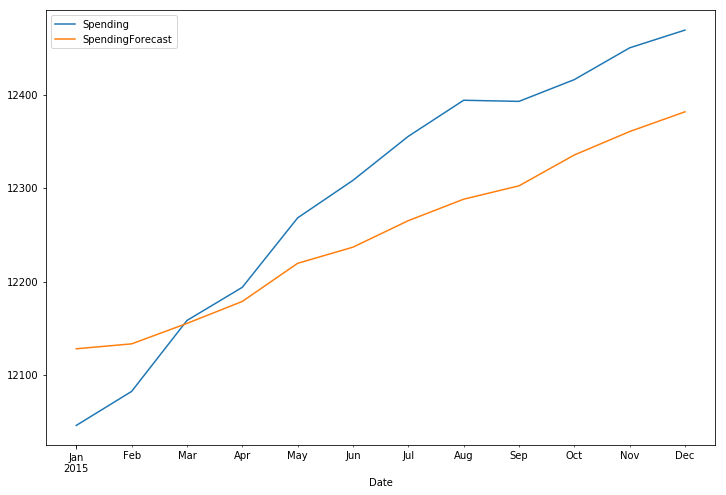

In [82]:
df[-nobs:]['Spending'].plot(legend=True,figsize=(12,8))
df_forecast['SpendingForecast'].plot(legend=True)

In [83]:
rmse(df[-nobs:]['Money'],df_forecast['MoneyForecast'])

134.3255580726628

In [84]:
df[-nobs:]['Money'].mean()

12034.008333333333

In [85]:
rmse(df[-nobs:]['Spending'],df_forecast['SpendingForecast'])

74.57640272399209

In [87]:
df[-nobs:]['Spending'].mean()

12294.533333333335

### VARMA

In [88]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [89]:
from pmdarima import auto_arima

In [90]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 2, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [91]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [92]:
df_transformed.head()

,Money,Spending
Date,,
1995-04-01,3.2,-64.8
1995-05-01,10.0,67.9
1995-06-01,-17.2,-36.6
1995-07-01,-5.9,-53.2
1995-08-01,9.3,94.1


In [93]:
nobs=12
train, test = df_transformed[:-nobs],df_transformed[-nobs:]

### fitting model

In [101]:
model = VARMAX(train,order=(1,2),trend='c')
results = model.fit(maxiter=1000,disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,237
Model:,"VARMA(1,2)",Log Likelihood,-2390.016
,+ intercept,AIC,4814.031
Date:,"Tue, 23 Jul 2019",BIC,4872.988
Time:,09:15:51,HQIC,4837.795
Sample:,04-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"97.97, 101.98",Jarque-Bera (JB):,"386.04, 106.47"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"3.61, 1.52",Skew:,"-1.06, 0.33"


In [102]:
df_forecast = results.forecast(12)

In [105]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [106]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [107]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-54.314987,35.077045,24.285013,11615.785013,45.677045,12097.077045
2015-02-01,25.132058,-13.771814,49.417071,11640.917071,31.905231,12083.305231
2015-03-01,-13.865279,5.030351,35.551792,11627.051792,36.935582,12088.335582
2015-04-01,3.133562,-0.188043,38.685354,11630.185354,36.747539,12088.147539
2015-05-01,-4.611304,0.354583,34.074050,11625.574050,37.102122,12088.502122
2015-06-01,-0.876129,1.174794,33.197921,11624.697921,38.276916,12089.676916
2015-07-01,-2.799290,0.149846,30.398631,11621.898631,38.426762,12089.826762
2015-08-01,-1.741268,1.028144,28.657362,11620.157362,39.454905,12090.854905
2015-09-01,-2.358725,0.362039,26.298637,11617.798637,39.816944,12091.216944
2015-10-01,-1.981100,0.840090,24.317537,11615.817537,40.657035,12092.057035


In [108]:
df_merged = pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

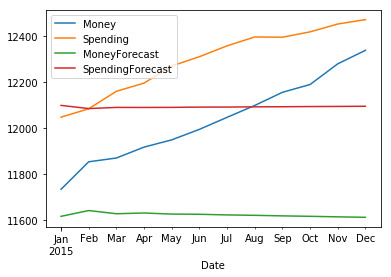

In [109]:
df_merged.plot(legend=True)

In [110]:
rmse(df_merged['Money'],df_merged['MoneyForecast'])

449.46893679203544

In [111]:
rmse(df_merged['Spending'],df_merged['SpendingForecast'])

245.99446031834196